# Nonparametric models
* Kernel density estimation
 * Input data is discrete (e.g. sightings of a particular species in space)
 * Estimate probability distribution from sample
 * Can also be used as a generative model (draw samples from approximate probability distribution)
* Gaussian processes
 * Input data is continuous (e.g. rainfall recordings taken at random intervals)
 * Uses correlations between training data points to predict test data points in interval
 * Also can be used as a generative model (whole lines can be drawn from a fitted model)
 * Can be generalised to higher dimensions (Gaussian random field)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


/Users/u1472179/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data = pd.read_csv("http://projects.fivethirtyeight.com/general-model/president_general_polls_2016.csv")

In [3]:
data.head()

,cycle,branch,type,matchup,forecastdate,state,startdate,enddate,pollster,grade,...,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,multiversions,url,poll_id,question_id,createddate,timestamp
0,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/4/16,U.S.,10/28/2016,11/1/2016,Ipsos,A-,...,44.37237,37.85611,5.384532,NaN,NaN,http://polling.reuters.com/#poll/TM651Y15_26/f...,48114,75376,11/2/16,16:55:39 4 Nov 2016
1,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/4/16,U.S.,10/30/2016,11/2/2016,ABC News/Washington Post,A+,...,45.24564,42.98823,3.171798,NaN,NaN,https://www.washingtonpost.com/news/the-fix/wp...,48268,75634,11/4/16,16:55:39 4 Nov 2016
2,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/4/16,Wisconsin,10/26/2016,10/31/2016,Marquette University,A,...,45.76629,41.22703,2.372862,NaN,NaN,https://twitter.com/MULawPoll,48095,75264,11/2/16,16:55:39 4 Nov 2016
3,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/4/16,Virginia,11/3/2016,11/4/2016,Public Policy Polling,B+,...,47.26656,42.18560,2.086879,NaN,NaN,http://www.publicpolicypolling.com/pdf/2015/PP...,48349,75743,11/4/16,16:55:39 4 Nov 2016
4,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/4/16,U.S.,10/31/2016,10/31/2016,Gravis Marketing,B-,...,46.10751,44.81306,4.149564,NaN,NaN,http://www.realclearpolitics.com/docs/2016/Gra...,48262,75570,11/3/16,16:55:39 4 Nov 2016


In [4]:
data.columns.values

array(['cycle', 'branch', 'type', 'matchup', 'forecastdate', 'state',
       'startdate', 'enddate', 'pollster', 'grade', 'samplesize',
       'population', 'poll_wt', 'rawpoll_clinton', 'rawpoll_trump',
       'rawpoll_johnson', 'rawpoll_mcmullin', 'adjpoll_clinton',
       'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin',
       'multiversions', 'url', 'poll_id', 'question_id', 'createddate',
       'timestamp'], dtype=object)

In [5]:
data.pollster.value_counts()

Ipsos                                                         2529
Google Consumer Surveys                                       2073
SurveyMonkey                                                  1518
Rasmussen Reports/Pulse Opinion Research                       354
USC Dornsife/LA Times                                          351
CVOTER International                                           336
The Times-Picayune/Lucid                                       312
Public Policy Polling                                          264
YouGov                                                         216
Emerson College                                                204
Quinnipiac University                                          174
Morning Consult                                                168
Gravis Marketing                                               159
Marist College                                                 138
SurveyUSA                                                     

In [6]:
print('president rows {} out of total rows {}'.format(np.sum(data.branch == 'President'),
len(data.index)))

president rows 11259 out of total rows 11259


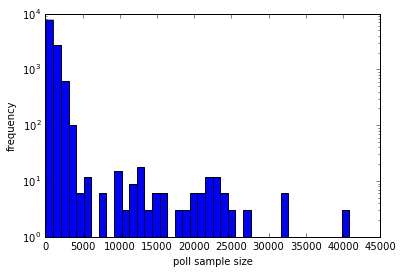

In [7]:
plt.hist(data.samplesize.dropna().values,bins=40);
plt.yscale('log');
plt.ylabel('frequency'); plt.xlabel('poll sample size');

## Clean data

In [8]:
data.forecastdate = pd.to_datetime(data.forecastdate)
data.createddate = pd.to_datetime(data.createddate)

In [9]:
t0 = np.datetime64('2016-11-08')
data.time2election = (data.createddate.values - t0).astype('timedelta64[D]')
data.time2election = data.time2election.astype(float)

In [10]:
national_data = data[data.state=='U.S.']

In [11]:
len(national_data.index)

3192

Remove NAs from poll date or sample size

In [12]:
national_data = national_data[np.isfinite(national_data.samplesize)]

In [13]:
national_data.samplesize.values.shape

(3192,)

## Kernel density estimation of pollster times

In [14]:
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

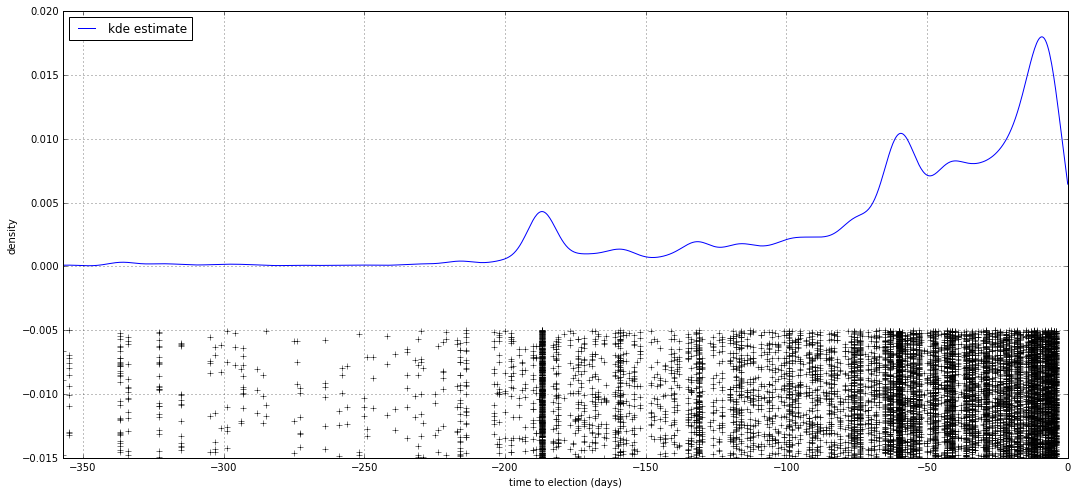

In [15]:
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.atleast_2d(data.time2election).T

X_plot = np.atleast_2d(np.linspace(X.min(), 0, 1000)).T
plt.figure(figsize=(18,8))



kde = KernelDensity(kernel='gaussian', bandwidth=5.0).fit(X)
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens), '-',
        label="kde estimate")


plt.legend(loc='upper left')
plt.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

plt.xlim(X.min(), 0)
plt.ylim(-0.015, 0.02)
plt.grid()
plt.xlabel('time to election (days)')
plt.ylabel('density')
plt.show()

## Predict popular vote using data from one pollster

Only look at one pollster to reduce data size

In [16]:
national_data = national_data[national_data.pollster == 'YouGov']#data = data[data.pollster == 'Google Consumer Surveys']

In [17]:
national_data.time2election = (national_data.createddate.values - t0).astype('timedelta64[D]')
national_data.time2election = national_data.time2election.astype(float)

In [18]:
len(national_data.index)

78

In [19]:
#data = data[data.time2election>-14.]

In [20]:
#data.time2election = (data.createddate.values - t0).astype('timedelta64[D]')
#data.time2election = data.time2election.astype(float)

## Gaussian Process Regressor

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [22]:
mpoll = np.mean(national_data.rawpoll_clinton)
sigpoll = 100.
p_clinton = np.array(national_data.rawpoll_clinton/sigpoll)
X = (np.atleast_2d(national_data.time2election).T).astype(float)
y = p_clinton - (mpoll)/sigpoll
#dy = 0.1*np.ones(len(y))/sigpoll#one point error
dy = p_clinton*(1-p_clinton)/national_data.samplesize.values

In [23]:
#kernel = C(1.0, (1e-3, 1e3)) * RBF(7., (1e-2, 30.))
#kernel = 1.0 * RBF(length_scale=7.0, length_scale_bounds=(1e-2, 30.0))
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

In [24]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y) ** 2,
                              n_restarts_optimizer=10)


In [25]:
gp.fit(X, y)  

GaussianProcessRegressor(alpha=array([  2.91595e-05,   3.03287e-05, ...,   3.15727e-05,   4.14705e-04]),
             copy_X_train=True, kernel=1**2 * RBF(length_scale=10),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [26]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
x = np.atleast_2d(np.linspace(-250., 0, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

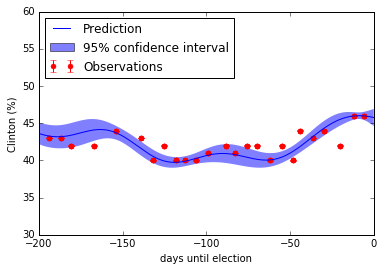

In [27]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
py = sigpoll*y+mpoll
pdy = sigpoll*dy
py_pred = sigpoll*y_pred+mpoll
psigma = sigpoll*sigma 
plt.errorbar(X.ravel(), py, pdy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, py_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([py_pred - 1.9600 * psigma,
                        (py_pred + 1.9600 * psigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('days until election')
plt.ylabel('Clinton (%)')
plt.ylim(30., 60.)
plt.xlim(-200.,0.)
plt.legend(loc='upper left')

plt.show()

## Next Steps
* Use more realistic noise model using sample errors
* Fit to other polling companies
* Predict Trump percentage and use to predict who will win popular vote
* Extend model to include biases for polling companies

In [28]:
mpoll = np.mean(national_data.rawpoll_trump)
sigpoll = 100.
p_trump = np.array(national_data.rawpoll_trump/sigpoll)
Ty = p_trump - (mpoll)/sigpoll
#dy = 0.1*np.ones(len(y))/sigpoll#one point error
Tdy = (p_trump*(1-p_trump)/national_data.samplesize.values)

In [29]:
Tgp = GaussianProcessRegressor(kernel=kernel, alpha=(Tdy / Ty) ** 2,
                              n_restarts_optimizer=10)
Tgp.fit(X, Ty)  

GaussianProcessRegressor(alpha=array([  2.16801e-05,   7.77431e-05, ...,   4.36763e-05,   2.04680e-05]),
             copy_X_train=True, kernel=1**2 * RBF(length_scale=10),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [30]:
#Predict for Trump
Ty_pred, Tsigma = Tgp.predict(x, return_std=True)

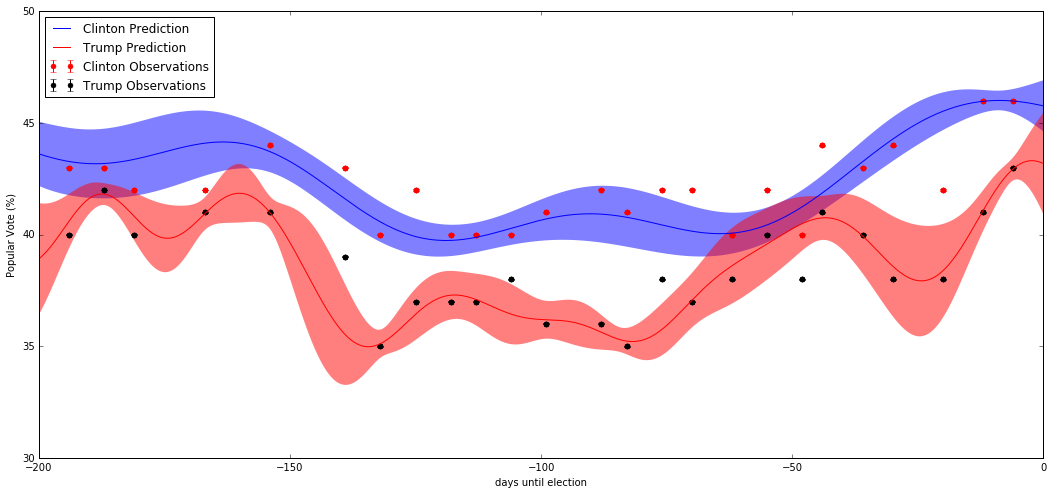

In [31]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure(figsize=(18,8))
Tpy = sigpoll*Ty+mpoll
Tpdy = sigpoll*Tdy
Tpy_pred = sigpoll*Ty_pred+mpoll
Tpsigma = sigpoll*Tsigma 
plt.errorbar(X.ravel(), py, pdy, fmt='r.', markersize=10, label=u'Clinton Observations')
plt.plot(x, py_pred, 'b-', label=u'Clinton Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([py_pred - 1.9600 * psigma,
                        (py_pred + 1.9600 * psigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label=None)
plt.errorbar(X.ravel(), Tpy, Tpdy, fmt='k.', markersize=10, label=u'Trump Observations')
plt.plot(x, Tpy_pred, 'r-', label=u'Trump Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([Tpy_pred - 1.9600 * Tpsigma,
                        (Tpy_pred + 1.9600 * Tpsigma)[::-1]]),
         alpha=.5, fc='r', ec='None', label=None)
plt.xlabel('days until election')
plt.ylabel('Popular Vote (%)')
plt.ylim(30., 50.)
plt.xlim(-200.,0.)
plt.legend(loc='upper left');

#plt.savefig('pres_pred.png',bbox_inches='tight')

In [124]:
GaussianProcessRegressor?